In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn for cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# torchsummary for model summary
try:
    from torchsummary import summary
    TORCHSUMMARY_AVAILABLE = True
except ImportError:
    TORCHSUMMARY_AVAILABLE = False
    print("torchsummary not available. Install with: pip install torchsummary")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Data path configuration
data_root = '/kaggle/input/dataset/USA_segmentation'
mask_dir = os.path.join(data_root, 'masks')
rgb_dir = os.path.join(data_root, 'RGB_images')
nrg_dir = os.path.join(data_root, 'NRG_images')

# Check if data directories exist
for directory in [mask_dir, rgb_dir, nrg_dir]:
    if not os.path.exists(directory):
        print(f'Warning: Directory {directory} does not exist!')
    else:
        print(f'Directory {directory} exists')

# Get file lists
mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
rgb_files = sorted(glob.glob(os.path.join(rgb_dir, '*.png')))
nrg_files = sorted(glob.glob(os.path.join(nrg_dir, '*.png')))

print(f'Found {len(mask_files)} mask files')
print(f'Found {len(rgb_files)} RGB files')
print(f'Found {len(nrg_files)} NRG files')

Directory /kaggle/input/dataset/USA_segmentation/masks exists
Directory /kaggle/input/dataset/USA_segmentation/RGB_images exists
Directory /kaggle/input/dataset/USA_segmentation/NRG_images exists
Found 444 mask files
Found 444 RGB files
Found 444 NRG files


In [ ]:
# Check data filename correspondence
def extract_filename_key(filepath):
    """Extract key identifier from file path"""
    filename = os.path.basename(filepath)
    # Remove prefix based on filename prefix
    if filename.startswith('mask_'):
        return filename[5:]  # Remove 'mask_' prefix
    elif filename.startswith('RGB_'):
        return filename[4:]  # Remove 'RGB_' prefix
    elif filename.startswith('NRG_'):
        return filename[4:]  # Remove 'NRG_' prefix
    return filename

# Check filename correspondence
mask_keys = [extract_filename_key(f) for f in mask_files]
rgb_keys = [extract_filename_key(f) for f in rgb_files]
nrg_keys = [extract_filename_key(f) for f in nrg_files]

print(f'Sample mask keys: {mask_keys[:5]}')
print(f'Sample RGB keys: {rgb_keys[:5]}')
print(f'Sample NRG keys: {nrg_keys[:5]}')

# Find common files across all three data types
common_keys = set(mask_keys) & set(rgb_keys) & set(nrg_keys)
print(f'Common files across all three types: {len(common_keys)}')

# Create matched file list
matched_files = []
for key in common_keys:
    mask_file = next((f for f in mask_files if extract_filename_key(f) == key), None)
    rgb_file = next((f for f in rgb_files if extract_filename_key(f) == key), None)
    nrg_file = next((f for f in nrg_files if extract_filename_key(f) == key), None)
    
    if mask_file and rgb_file and nrg_file:
        matched_files.append({
            'key': key,
            'mask': mask_file,
            'rgb': rgb_file,
            'nrg': nrg_file
        })

print(f'Successfully matched {len(matched_files)} files')

Sample mask keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample RGB keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample NRG keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Common files across all three types: 444
Successfully matched 444 files


Death tree ratio statistics:
Mean: 0.0189
Median: 0.0132
Std: 0.0177
Min: 0.0000
Max: 0.1272


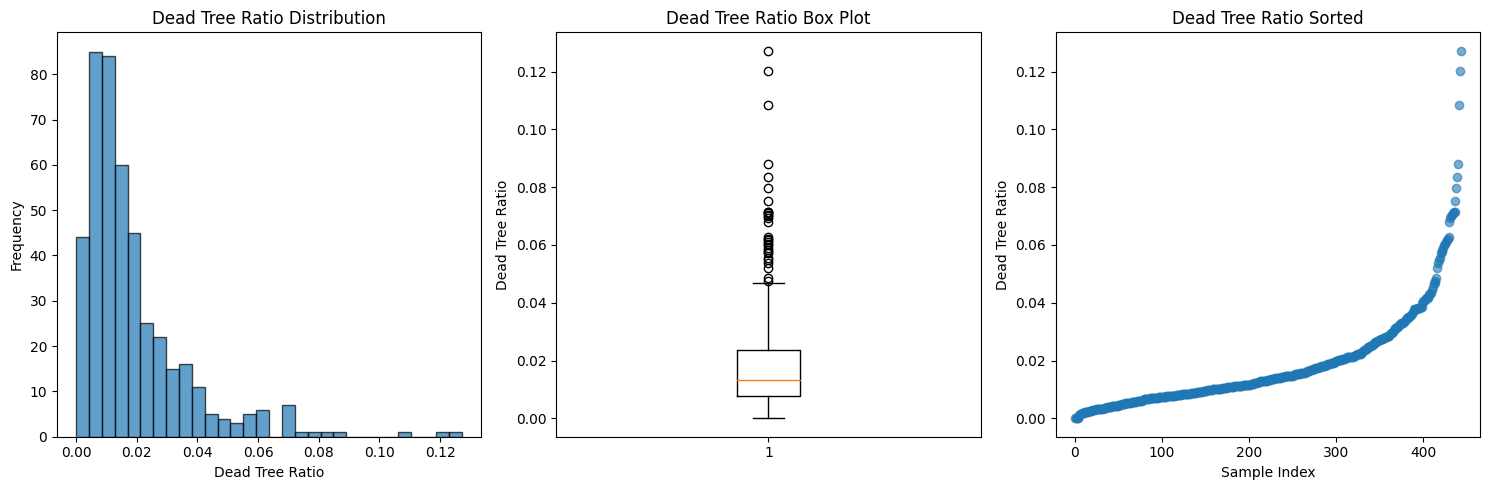

In [ ]:
# Dead tree pixel ratio statistics
def calculate_dead_tree_ratio(mask_path):
    """Calculate dead tree pixel ratio"""
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return 0.0
        
        # Assume dead tree pixels are non-zero values
        dead_tree_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        
        return dead_tree_pixels / total_pixels if total_pixels > 0 else 0.0
    except Exception as e:
        print(f'Error processing {mask_path}: {e}')
        return 0.0

# Calculate dead tree ratio for each mask
dead_tree_ratios = []
for file_info in matched_files:
    ratio = calculate_dead_tree_ratio(file_info['mask'])
    dead_tree_ratios.append(ratio)
    file_info['dead_tree_ratio'] = ratio

# Statistical analysis
ratios_array = np.array(dead_tree_ratios)
print(f'Death tree ratio statistics:')
print(f'Mean: {np.mean(ratios_array):.4f}')
print(f'Median: {np.median(ratios_array):.4f}')
print(f'Std: {np.std(ratios_array):.4f}')
print(f'Min: {np.min(ratios_array):.4f}')
print(f'Max: {np.max(ratios_array):.4f}')

# Visualize dead tree ratio distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ratios_array, bins=30, alpha=0.7, edgecolor='black')
plt.title('Dead Tree Ratio Distribution')
plt.xlabel('Dead Tree Ratio')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(ratios_array)
plt.title('Dead Tree Ratio Box Plot')
plt.ylabel('Dead Tree Ratio')

plt.subplot(1, 3, 3)
plt.scatter(range(len(ratios_array)), sorted(ratios_array), alpha=0.6)
plt.title('Dead Tree Ratio Sorted')
plt.xlabel('Sample Index')
plt.ylabel('Dead Tree Ratio')

plt.tight_layout()
plt.show()

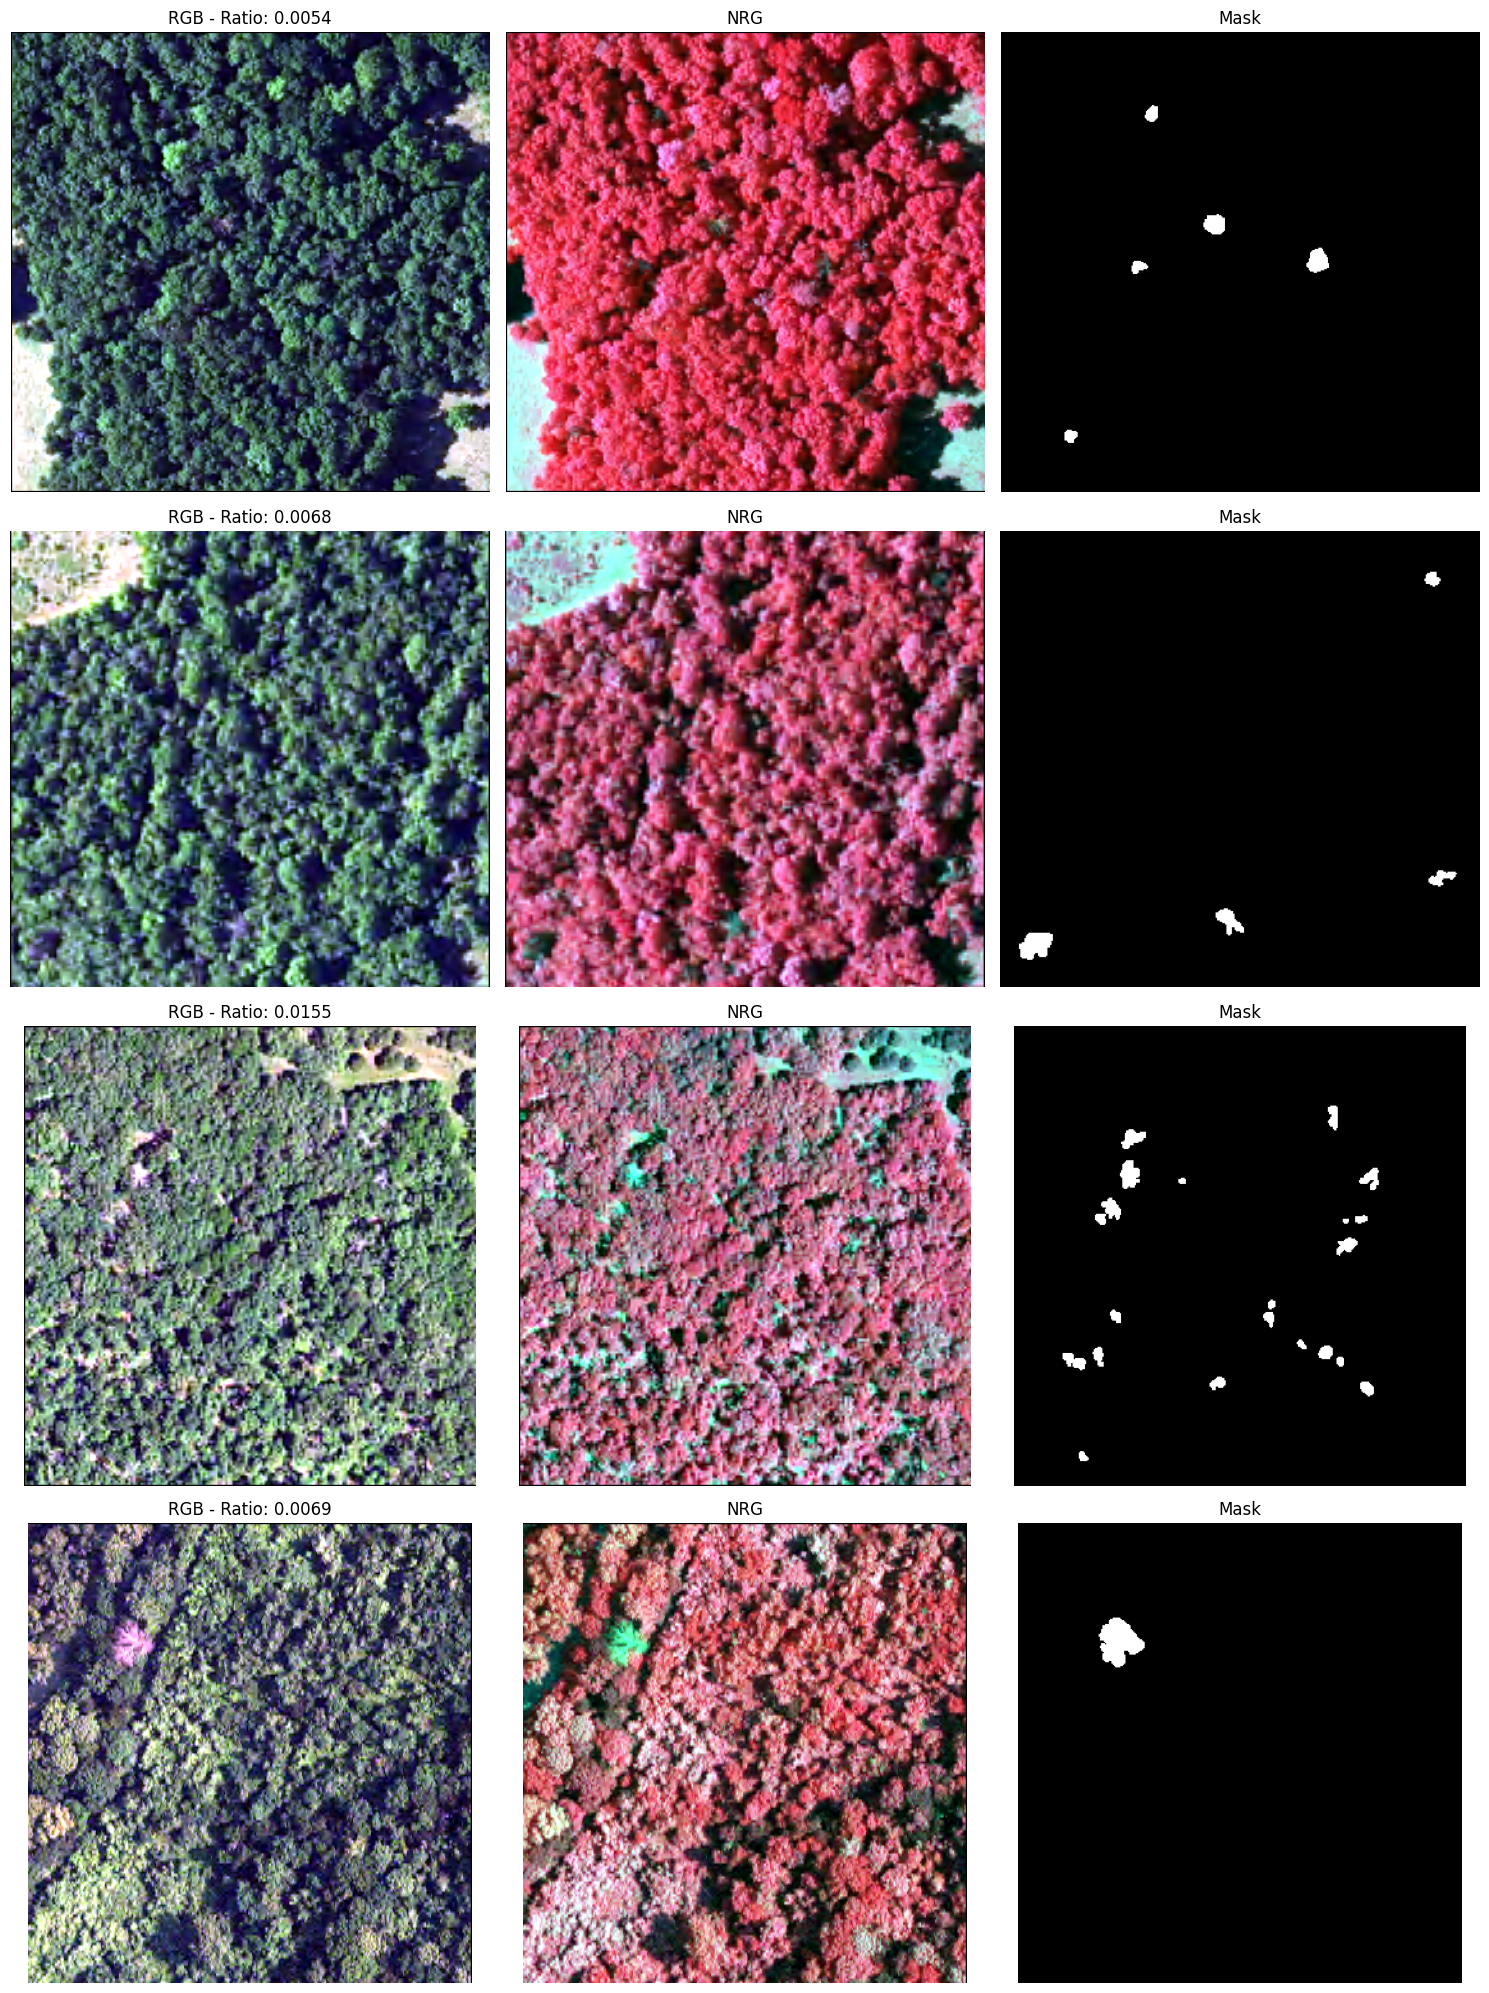

In [ ]:
# Sample image visualization
def visualize_samples(matched_files, num_samples=4):
    """Visualize sample images"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    sample_indices = np.random.choice(len(matched_files), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        file_info = matched_files[idx]
        
        # Load images
        try:
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            
            mask_img = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
            
            # Display images
            axes[i, 0].imshow(rgb_img)
            axes[i, 0].set_title(f'RGB - Ratio: {file_info["dead_tree_ratio"]:.4f}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(nrg_img)
            axes[i, 1].set_title('NRG')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(mask_img, cmap='gray')
            axes[i, 2].set_title('Mask')
            axes[i, 2].axis('off')
            
        except Exception as e:
            print(f'Error loading images for sample {idx}: {e}')
    
    plt.tight_layout()
    plt.show()

visualize_samples(matched_files)

In [ ]:
# Stratified split function
def create_stratified_splits(matched_files, n_splits=5, test_size=0.2):
    """Create stratified K-fold splits"""
    # Extract dead tree ratios
    ratios = [f['dead_tree_ratio'] for f in matched_files]
    
    # Create stratified labels (low, medium, high content)
    ratio_percentiles = np.percentile(ratios, [33, 67])
    stratify_labels = []
    
    for ratio in ratios:
        if ratio <= ratio_percentiles[0]:
            stratify_labels.append(0)  # Low content
        elif ratio <= ratio_percentiles[1]:
            stratify_labels.append(1)  # Medium content
        else:
            stratify_labels.append(2)  # High content
    
    print(f'Stratification distribution:')
    unique, counts = np.unique(stratify_labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f'  Class {label}: {count} samples ({count/len(stratify_labels)*100:.1f}%)')
    
    # First split test set
    from sklearn.model_selection import train_test_split
    
    indices = np.arange(len(matched_files))
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, stratify=stratify_labels, random_state=42
    )
    
    # Create K-fold cross validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_val_labels = [stratify_labels[i] for i in train_val_idx]
    
    folds = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_val_idx, train_val_labels)):
        fold_train_idx = train_val_idx[train_idx]
        fold_val_idx = train_val_idx[val_idx]
        
        fold_info = {
            'fold': fold_idx,
            'train_idx': fold_train_idx,
            'val_idx': fold_val_idx,
            'test_idx': test_idx
        }
        folds.append(fold_info)
    
    return folds, stratify_labels

# Create stratified K-fold splits
folds, stratify_labels = create_stratified_splits(matched_files, n_splits=5, test_size=0.2)

print(f'\nCreated {len(folds)} folds')
for i, fold in enumerate(folds):
    print(f'Fold {i}: Train={len(fold["train_idx"])}, Val={len(fold["val_idx"])}, Test={len(fold["test_idx"])}')

Stratification distribution:
  Class 0: 147 samples (33.1%)
  Class 1: 150 samples (33.8%)
  Class 2: 147 samples (33.1%)

Created 5 folds
Fold 0: Train=284, Val=71, Test=89
Fold 1: Train=284, Val=71, Test=89
Fold 2: Train=284, Val=71, Test=89
Fold 3: Train=284, Val=71, Test=89
Fold 4: Train=284, Val=71, Test=89


In [ ]:
class DeadTreeDataset(Dataset):
    """Dead tree segmentation dataset"""
    
    def __init__(self, matched_files, indices, input_type='rgb', transform=None, target_size=(256, 256)):
        """
        Args:
            matched_files: List of matched files
            indices: Data indices
            input_type: 'rgb', 'nrg' or 'rgb_nir'
            transform: Data augmentation
            target_size: Target image size
        """
        self.matched_files = matched_files
        self.indices = indices
        self.input_type = input_type
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        file_idx = self.indices[idx]
        file_info = self.matched_files[file_idx]
        
        if self.input_type == 'rgb':
            image = cv2.imread(file_info['rgb'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'nrg':
            image = cv2.imread(file_info['nrg'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'rgb_nir':
            # Load RGB
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            # Load NRG, take NIR channel (assume NIR is channel 0)
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            nir_channel = nrg_img[:, :, 0]
            # Combine to 4 channels
            image = np.concatenate([rgb_img, nir_channel[..., None]], axis=2)
        else:
            raise ValueError(f"Unknown input_type: {self.input_type}")
        
        # Load mask
        mask = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
        
        # Resize
        if image.shape[:2] != self.target_size:
            image = cv2.resize(image, self.target_size)
        if mask.shape != self.target_size:
            mask = cv2.resize(mask, self.target_size)
        
        # Binarize mask
        mask = (mask > 0).astype(np.uint8)
        
        # Ensure mask is [H, W], ToTensorV2 will convert to [1, H, W]
        # Apply data augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure mask is [1, H, W]
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        
        return image, mask.long()

# Data augmentation configuration
def get_transforms(phase='train', input_channels=3):
    """Get data augmentation configuration"""
    mean = [0.485, 0.456, 0.406] + ([0.5] if input_channels == 4 else [])
    std = [0.229, 0.224, 0.225] + ([0.25] if input_channels == 4 else [])
    if phase == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

# Test data loader
train_transform = get_transforms('train', input_channels=4)
val_transform = get_transforms('val', input_channels=4)

# Create test dataset
# Note: input_type='rgb_nir', 4 channels
test_dataset = DeadTreeDataset(
    matched_files, 
    folds[0]['train_idx'][:10], 
    input_type='rgb_nir',
    transform=train_transform
)

# Test data loading
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
sample_batch = next(iter(test_loader))
print(f'Sample batch - Image shape: {sample_batch[0].shape}, Mask shape: {sample_batch[1].shape}')
print(f'Image dtype: {sample_batch[0].dtype}, Mask dtype: {sample_batch[1].dtype}')

Sample batch - Image shape: torch.Size([2, 4, 256, 256]), Mask shape: torch.Size([2, 1, 256, 256])
Image dtype: torch.float32, Mask dtype: torch.int64


In [ ]:
class ConvBlock(nn.Module):
    """Basic convolution block for UNet++"""
    
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class VGGBlock(nn.Module):
    """VGG-style convolution block used in UNet++"""
    
    def __init__(self, in_channels, middle_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        self.conv2 = nn.Conv2d(middle_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        return out

class UNetPlusPlus(nn.Module):
    """UNet++ model implementation"""
    
    def __init__(self, in_channels=3, out_channels=1, deep_supervision=False):
        super(UNetPlusPlus, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.deep_supervision = deep_supervision
        
        # Define feature channel numbers
        nb_filter = [32, 64, 128, 256, 512]
        
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Build UNet++ nested structure
        # conv0_0 to conv0_4 (encoder path)
        self.conv0_0 = VGGBlock(in_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])
        
        # conv0_1 to conv3_1 (first nested path)
        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])
        
        # conv0_2 to conv2_2 (second nested path)
        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])
        
        # conv0_3 to conv1_3 (third nested path)
        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])
        
        # conv0_4 (final nested path)
        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])
        
        # Final output layers
        if self.deep_supervision:
            self.final1 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final2 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final3 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
            self.final4 = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        else:
            self.final = nn.Conv2d(nb_filter[0], out_channels, kernel_size=1)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
        # Encoder path
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], 1))
        
        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], 1))
        
        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], 1))
        
        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], 1))
        
        # Output
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [self.sigmoid(output1), self.sigmoid(output2), 
                    self.sigmoid(output3), self.sigmoid(output4)]
        else:
            output = self.final(x0_4)
            return self.sigmoid(output)

# Model configuration
def create_model(input_type='rgb', device='cuda', deep_supervision=False):
    """Create UNet++ model"""
    # Determine channel number based on input type
    if input_type == 'rgb_nir':
        in_channels = 4
    else:
        in_channels = 3
    
    model = UNetPlusPlus(
        in_channels=in_channels,
        out_channels=1,
        deep_supervision=deep_supervision
    )
    return model.to(device)

def display_model_info(model, input_shape, device):
    """Display detailed model information"""
    print("="*60)
    print("MODEL INFORMATION")
    print("="*60)
    
    # Basic information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Architecture: UNet++")
    print(f"Input Channels: {model.in_channels}")
    print(f"Output Channels: {model.out_channels}")
    print(f"Deep Supervision: {model.deep_supervision}")
    print(f"Input Shape: {input_shape}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Model Size (MB): {total_params * 4 / (1024**2):.2f}")
    
    # Use torchsummary to display detailed structure
    if TORCHSUMMARY_AVAILABLE:
        print("\n" + "="*60)
        print("DETAILED ARCHITECTURE SUMMARY")
        print("="*60)
        summary(model, input_shape[1:])  # Remove batch dimension
    else:
        print(f"\nInstall torchsummary for detailed architecture: pip install torchsummary")
        print("\n" + "="*60)
        print("MODEL STRUCTURE OVERVIEW")
        print("="*60)
        print(model)

# Test model
print("Creating and testing 4-channel UNet++ model...")
test_model = create_model(input_type='rgb_nir', device=device, deep_supervision=False)
test_input = torch.randn(1, 4, 256, 256).to(device)  # 4-channel input test
test_output = test_model(test_input)

print(f'Model test - Input shape: {test_input.shape}, Output shape: {test_output.shape}')
print(f'Output range: [{test_output.min():.4f}, {test_output.max():.4f}]')

# Display detailed model information
display_model_info(test_model, test_input.shape, device)

Creating and testing 4-channel UNet++ model...
Model test - Input shape: torch.Size([1, 4, 256, 256]), Output shape: torch.Size([1, 1, 256, 256])
Output range: [0.1539, 0.8915]
MODEL INFORMATION
Model Architecture: UNet++
Input Channels: 4
Output Channels: 1
Deep Supervision: False
Input Shape: torch.Size([1, 4, 256, 256])
Total Parameters: 9,163,617
Trainable Parameters: 9,163,617
Model Size (MB): 34.96

DETAILED ARCHITECTURE SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           1,184
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
          VGGBlock-7         [-1, 32, 256, 256] 

In [ ]:
class DiceLoss(nn.Module):
    """Dice loss function"""
    
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        # Flatten
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss function, supports deep supervision"""
    
    def __init__(self, alpha=0.5, deep_supervision=False):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.deep_supervision = deep_supervision
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, inputs, targets):
        targets = targets.float()
        
        if self.deep_supervision and isinstance(inputs, list):
            # Deep supervision mode: calculate loss for each output
            total_loss = 0
            for i, output in enumerate(inputs):
                weight = 0.5 ** i  # Give different weights to different levels
                bce_loss = self.bce(output, targets)
                dice_loss = self.dice(output, targets)
                loss = self.alpha * bce_loss + (1 - self.alpha) * dice_loss
                total_loss += weight * loss
            return total_loss
        else:
            # Standard mode: single output
            bce_loss = self.bce(inputs, targets)
            dice_loss = self.dice(inputs, targets)
            return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

# Evaluation metrics
def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU"""
    # If pred is list (deep supervision), use the last output
    if isinstance(pred, list):
        pred = pred[-1]
    
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    
    if union == 0:
        return 1.0
    return (intersection / union).item()

def calculate_dice_coefficient(pred, target, threshold=0.5):
    """Calculate Dice coefficient"""
    # If pred is list (deep supervision), use the last output
    if isinstance(pred, list):
        pred = pred[-1]
    
    pred = (pred > threshold).float()
    target = target.float()
    
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum())
    
    if pred.sum() + target.sum() == 0:
        return 1.0
    return dice.item()

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    """Calculate pixel accuracy"""
    # If pred is list (deep supervision), use the last output
    if isinstance(pred, list):
        pred = pred[-1]
    
    pred = (pred > threshold).float()
    target = target.float()
    
    correct = (pred == target).sum()
    total = target.numel()
    
    return (correct / total).item()

# Test loss functions
# Test standard mode
criterion = CombinedLoss(deep_supervision=False)
test_pred = torch.sigmoid(torch.randn(4, 1, 256, 256))
test_target = torch.randint(0, 2, (4, 1, 256, 256)).float()
test_loss = criterion(test_pred, test_target)
print(f'Standard mode test loss: {test_loss.item():.4f}')

# Test deep supervision mode
criterion_ds = CombinedLoss(deep_supervision=True)
test_pred_list = [torch.sigmoid(torch.randn(4, 1, 256, 256)) for _ in range(4)]
test_loss_ds = criterion_ds(test_pred_list, test_target)
print(f'Deep supervision mode test loss: {test_loss_ds.item():.4f}')

# Test evaluation metrics
test_iou = calculate_iou(test_pred, test_target)
test_dice = calculate_dice_coefficient(test_pred, test_target)
test_acc = calculate_pixel_accuracy(test_pred, test_target)
print(f'Test IoU: {test_iou:.4f}, Dice: {test_dice:.4f}, Accuracy: {test_acc:.4f}')

Standard mode test loss: 0.6529
Deep supervision mode test loss: 1.2240
Test IoU: 0.3337, Dice: 0.5004, Accuracy: 0.5003


In [ ]:
class EarlyStopping:
    """Early stopping mechanism"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        
        return self.counter >= self.patience
    
    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()
    
    def restore_best_weights_to_model(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train one epoch"""
    model.train()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        images, masks = images.to(device), masks.to(device)
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)  # Ensure mask is [batch, 1, H, W]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate metrics
        with torch.no_grad():
            total_iou += calculate_iou(outputs, masks)
            total_dice += calculate_dice_coefficient(outputs, masks)
            total_acc += calculate_pixel_accuracy(outputs, masks)
    
    n_batches = len(dataloader)
    return {
        'loss': total_loss / n_batches,
        'iou': total_iou / n_batches,
        'dice': total_dice / n_batches,
        'accuracy': total_acc / n_batches
    }

def validate_epoch(model, dataloader, criterion, device):
    """Validate one epoch"""
    model.eval()
    total_loss = 0
    total_iou = 0
    total_dice = 0
    total_acc = 0
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)  # Ensure mask is [batch, 1, H, W]
            
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            
            total_loss += loss.item()
            total_iou += calculate_iou(outputs, masks)
            total_dice += calculate_dice_coefficient(outputs, masks)
            total_acc += calculate_pixel_accuracy(outputs, masks)
    
    n_batches = len(dataloader)
    return {
        'loss': total_loss / n_batches,
        'iou': total_iou / n_batches,
        'dice': total_dice / n_batches,
        'accuracy': total_acc / n_batches
    }

def train_fold(fold_info, matched_files, config):
    """Train one fold"""
    print(f"Training Fold {fold_info['fold']}")
    
    # Create datasets
    # Determine input channels
    input_channels = 4 if config['input_type'] == 'rgb_nir' else 3
    
    train_dataset = DeadTreeDataset(
        matched_files, fold_info['train_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('train', input_channels=input_channels)
    )
    
    val_dataset = DeadTreeDataset(
        matched_files, fold_info['val_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('val', input_channels=input_channels)
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], 
        shuffle=True, num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], 
        shuffle=False, num_workers=0
    )
    
    # Create UNet++ model
    model = create_model(config['input_type'], device, config.get('deep_supervision', False))
    
    # Create optimizer and loss function
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    criterion = CombinedLoss(deep_supervision=config.get('deep_supervision', False))
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_iou': [], 'val_iou': [],
        'train_dice': [], 'val_dice': [],
        'train_accuracy': [], 'val_accuracy': []
    }
    
    # Training loop
    for epoch in range(config['epochs']):
        # Training
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation
        val_metrics = validate_epoch(model, val_loader, criterion, device)
        
        # Record history
        for key in train_metrics:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'val_{key}'].append(val_metrics[key])
        
        # Learning rate adjustment
        scheduler.step(val_metrics['loss'])
        
        # Early stopping check
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Print progress
        if (epoch + 1) % 5 == 0:
            print(f'Epoch {epoch+1}/{config["epochs"]} - '
                  f'Train Loss: {train_metrics["loss"]:.4f}, '
                  f'Val Loss: {val_metrics["loss"]:.4f}, '
                  f'Val IoU: {val_metrics["iou"]:.4f}')
    
    # Restore best weights
    early_stopping.restore_best_weights_to_model(model)
    
    return model, history

In [ ]:
# Training configuration
config = {
    'input_type': 'rgb_nir',  # Use 4-channel RGB+NIR input
    'batch_size': 8,
    'learning_rate': 1e-4,
    'epochs': 600,  
    'patience': 7,
    'deep_supervision': True  # UNet++ deep supervision option, can be set to True to enable
}

print(f"UNet++ Configuration:")
print(f"- Architecture: UNet++ (Nested U-Net)")
print(f"- Input Type: {config['input_type']}")
print(f"- Deep Supervision: {config['deep_supervision']}")
print(f"- Batch Size: {config['batch_size']}")
print(f"- Learning Rate: {config['learning_rate']}")
print(f"- Max Epochs: {config['epochs']}")
print(f"- Early Stopping Patience: {config['patience']}")

# Select number of folds to train
n_folds_to_train = 5
fold_results = []

for i in range(n_folds_to_train):
    print(f"\n{'='*50}")
    print(f"Training UNet++ Fold {i+1}/{n_folds_to_train}")
    print(f"{'='*50}")
    
    # Train fold
    model, history = train_fold(folds[i], matched_files, config)
    
    # Save results
    fold_result = {
        'fold': i,
        'model': model,
        'history': history,
        'best_val_loss': min(history['val_loss']),
        'best_val_iou': max(history['val_iou']),
        'best_val_dice': max(history['val_dice'])
    }
    fold_results.append(fold_result)
    
    print(f"Fold {i} completed - Best Val IoU: {fold_result['best_val_iou']:.4f}")

print(f"\nUNet++ training completed for {n_folds_to_train} folds!")

UNet++ Configuration:
- Architecture: UNet++ (Nested U-Net)
- Input Type: rgb_nir
- Deep Supervision: True
- Batch Size: 8
- Learning Rate: 0.0001
- Max Epochs: 600
- Early Stopping Patience: 7

Training UNet++ Fold 1/2
Training Fold 0
Epoch 5/600 - Train Loss: 1.2964, Val Loss: 1.2974, Val IoU: 0.2436
Epoch 10/600 - Train Loss: 1.2141, Val Loss: 1.2109, Val IoU: 0.3037
Epoch 15/600 - Train Loss: 1.1536, Val Loss: 1.1505, Val IoU: 0.2732
Epoch 20/600 - Train Loss: 1.0928, Val Loss: 1.1021, Val IoU: 0.2639
Epoch 25/600 - Train Loss: 1.0386, Val Loss: 1.0393, Val IoU: 0.2901
Epoch 30/600 - Train Loss: 0.9879, Val Loss: 0.9923, Val IoU: 0.3268
Epoch 35/600 - Train Loss: 0.9417, Val Loss: 0.9360, Val IoU: 0.3403
Epoch 40/600 - Train Loss: 0.8934, Val Loss: 0.8864, Val IoU: 0.3649
Epoch 45/600 - Train Loss: 0.8453, Val Loss: 0.8516, Val IoU: 0.3590
Epoch 50/600 - Train Loss: 0.8003, Val Loss: 0.8357, Val IoU: 0.3045
Epoch 55/600 - Train Loss: 0.7540, Val Loss: 0.7718, Val IoU: 0.3702
Epoch 

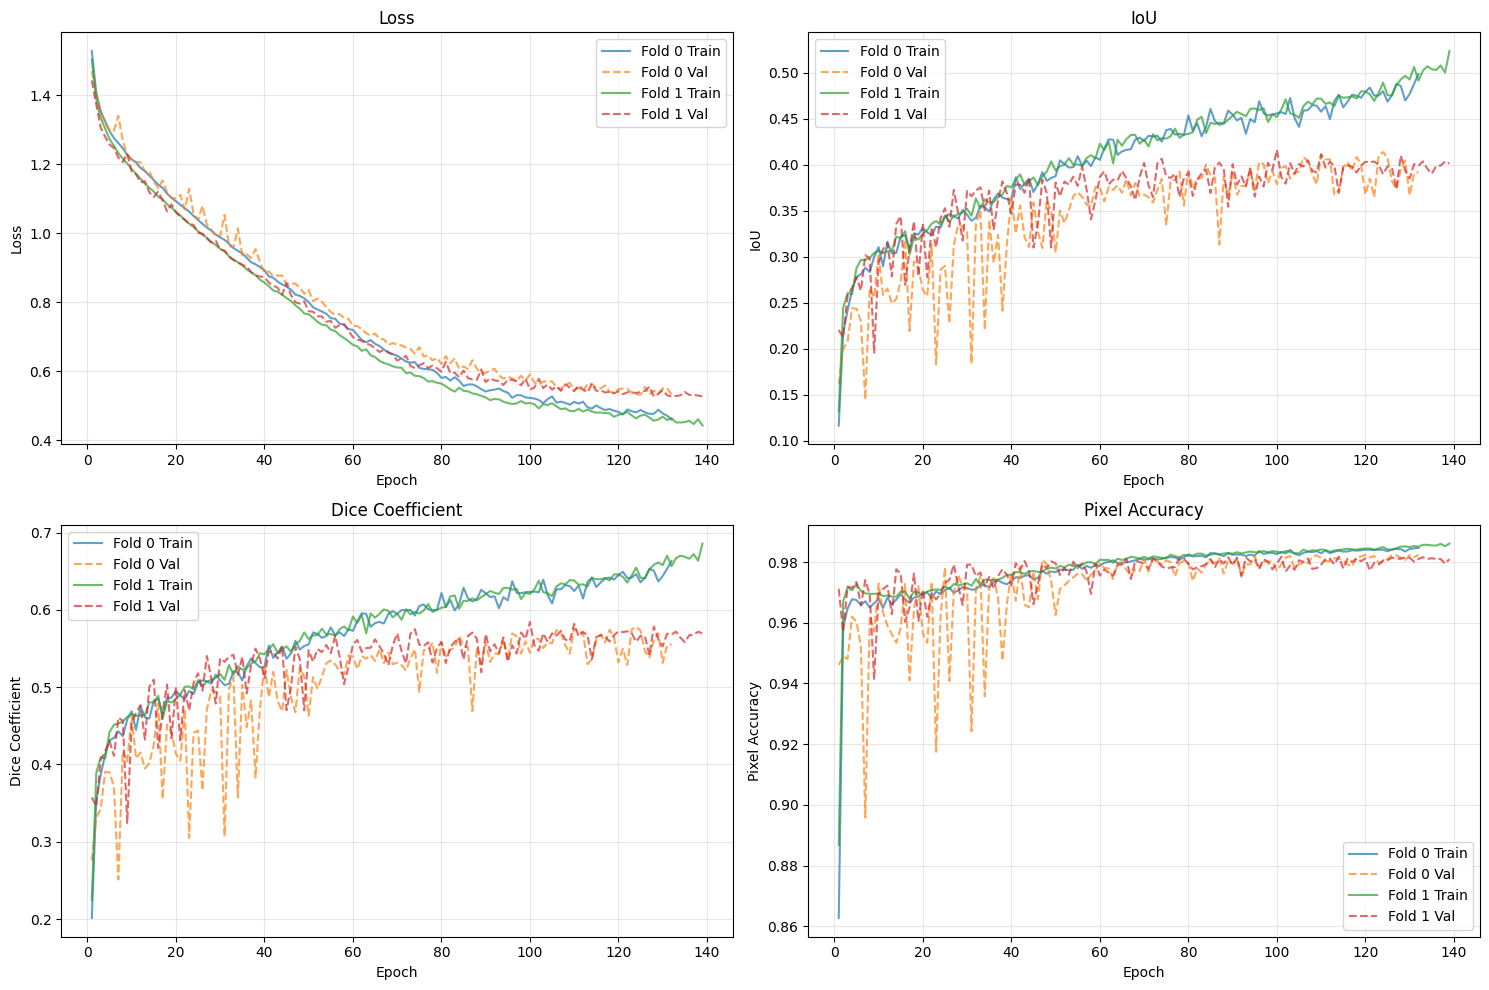

In [ ]:
# Plot training curves
def plot_training_curves(fold_results):
    """Plot training curves"""
    n_folds = len(fold_results)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['loss', 'iou', 'dice', 'accuracy']
    titles = ['Loss', 'IoU', 'Dice Coefficient', 'Pixel Accuracy']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        
        for fold_idx, fold_result in enumerate(fold_results):
            history = fold_result['history']
            epochs = range(1, len(history[f'train_{metric}']) + 1)
            
            ax.plot(epochs, history[f'train_{metric}'], 
                   label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
            ax.plot(epochs, history[f'val_{metric}'], 
                   label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training curves
plot_training_curves(fold_results)

Cross-Validation Results Summary:
 Fold  Val Loss  Val IoU  Val Dice
    0  0.532568 0.413640  0.578114
    1  0.526901 0.416112  0.584224

Statistics:
           Fold  Val Loss   Val IoU  Val Dice
count  2.000000  2.000000  2.000000  2.000000
mean   0.500000  0.529735  0.414876  0.581169
std    0.707107  0.004007  0.001748  0.004321
min    0.000000  0.526901  0.413640  0.578114
25%    0.250000  0.528318  0.414258  0.579641
50%    0.500000  0.529735  0.414876  0.581169
75%    0.750000  0.531152  0.415494  0.582697
max    1.000000  0.532568  0.416112  0.584224


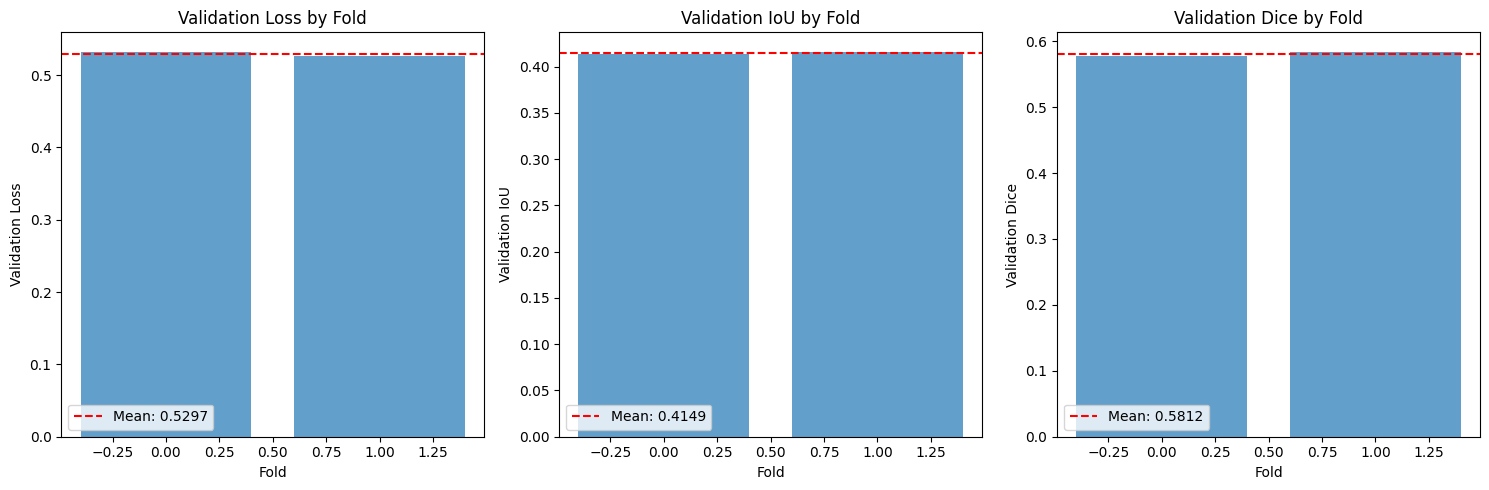

In [ ]:
# Cross-validation results summary
def summarize_cv_results(fold_results):
    """Summarize cross-validation results"""
    metrics = ['best_val_loss', 'best_val_iou', 'best_val_dice']
    metric_names = ['Validation Loss', 'Validation IoU', 'Validation Dice']
    
    results_df = pd.DataFrame()
    
    for fold_result in fold_results:
        fold_data = {
            'Fold': fold_result['fold'],
            'Val Loss': fold_result['best_val_loss'],
            'Val IoU': fold_result['best_val_iou'],
            'Val Dice': fold_result['best_val_dice']
        }
        results_df = pd.concat([results_df, pd.DataFrame([fold_data])], ignore_index=True)
    
    # Calculate statistics
    summary_stats = results_df.describe()
    
    print("Cross-Validation Results Summary:")
    print("="*50)
    print(results_df.to_string(index=False))
    print("\nStatistics:")
    print(summary_stats)
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (metric, name) in enumerate(zip(['Val Loss', 'Val IoU', 'Val Dice'], metric_names)):
        ax = axes[i]
        ax.bar(results_df['Fold'], results_df[metric], alpha=0.7)
        ax.set_title(f'{name} by Fold')
        ax.set_xlabel('Fold')
        ax.set_ylabel(name)
        
        # Add mean line
        mean_val = results_df[metric].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                  label=f'Mean: {mean_val:.4f}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Summarize results
cv_results = summarize_cv_results(fold_results)

Visualizing UNet++ predictions from best fold (Fold 1)
Deep supervision mode: using final output from 1 levels
Deep supervision mode: using final output from 1 levels
Deep supervision mode: using final output from 1 levels
Deep supervision mode: using final output from 1 levels


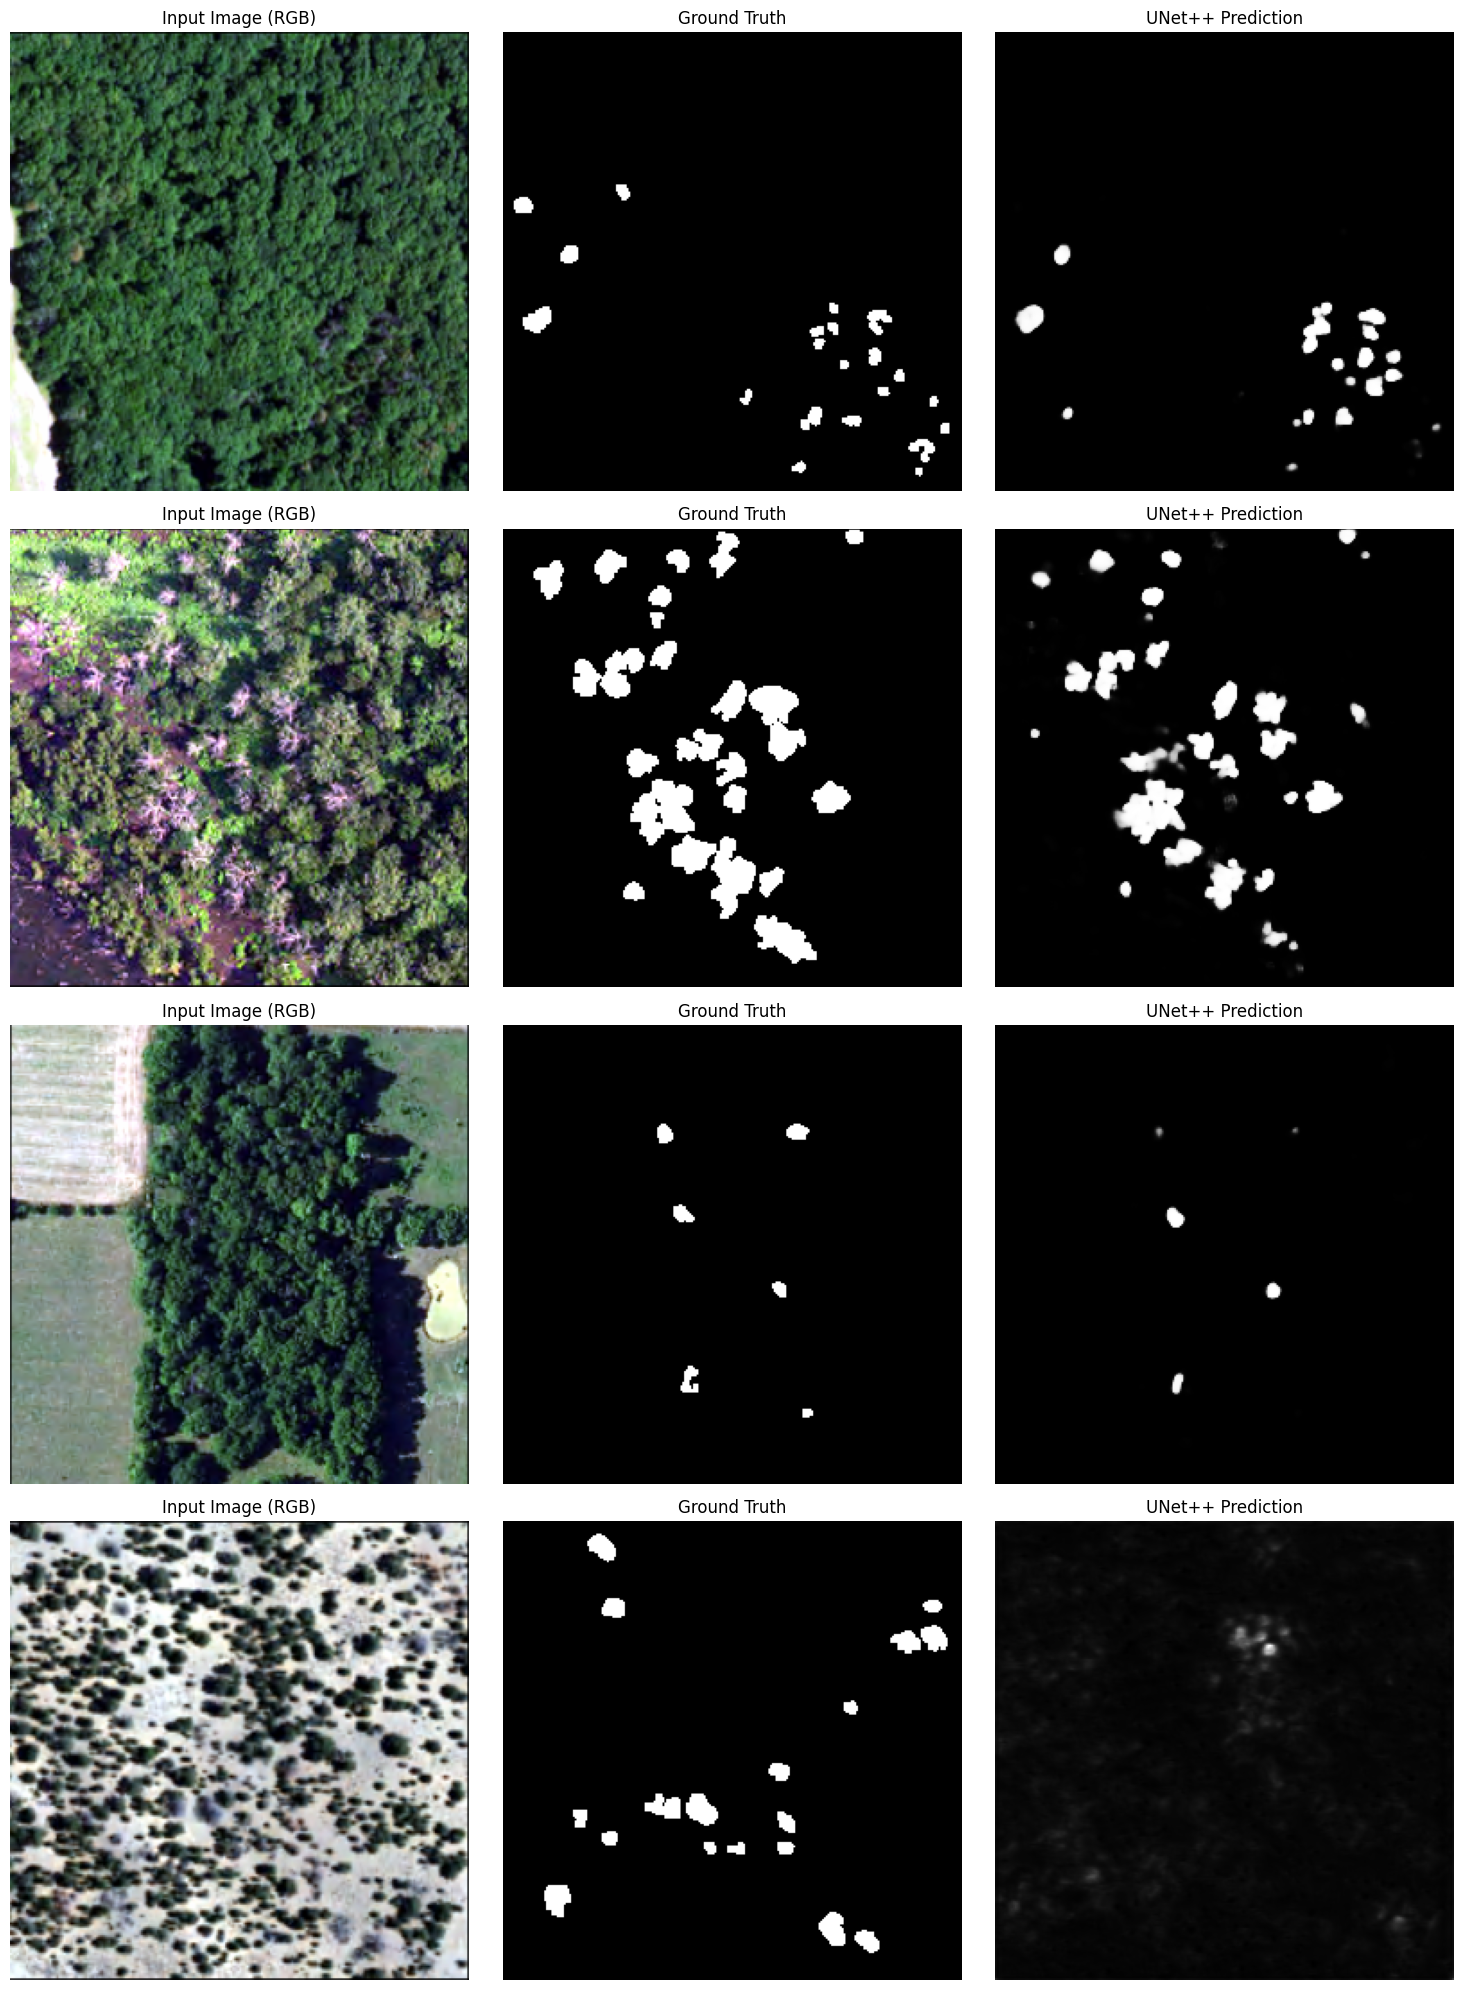

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=4):
    """Visualize UNet++ model prediction results"""
    model.eval()
    
    # Randomly select samples
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            image, mask = dataset[idx]
            
            # Prediction
            image_input = image.unsqueeze(0).to(device)
            pred = model(image_input)
            
            # If deep supervision mode, use the last output
            if isinstance(pred, list):
                pred = pred[-1]  # Use the deepest layer output
                print(f"Deep supervision mode: using final output from {len(pred)} levels")
            
            pred = pred.cpu().numpy()[0, 0]  # Model already includes sigmoid
            
            # Denormalize image for display (only show first 3 channels RGB)
            image_np = image.numpy().transpose(1, 2, 0)
            if image_np.shape[2] == 4:
                # 4-channel case, only take first 3 channels for display
                image_np = image_np[:, :, :3]
            
            # Denormalize (only for RGB three channels)
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            # Process mask for display
            mask_np = mask.numpy()
            if mask_np.ndim == 3 and mask_np.shape[0] == 1:
                mask_np = mask_np[0]  # Convert from [1, H, W] to [H, W]
            
            # Display images
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Input Image (RGB)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred, cmap='gray')
            axes[i, 2].set_title('UNet++ Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize best UNet++ model prediction results
if fold_results:
    best_fold = max(fold_results, key=lambda x: x['best_val_iou'])
    print(f"Visualizing UNet++ predictions from best fold (Fold {best_fold['fold']})")
    
    # Create validation dataset
    input_channels = 4 if config['input_type'] == 'rgb_nir' else 3
    val_dataset = DeadTreeDataset(
        matched_files, 
        folds[best_fold['fold']]['val_idx'],
        input_type=config['input_type'],
        transform=get_transforms('val', input_channels=input_channels)
    )
    
    visualize_predictions(best_fold['model'], val_dataset, device)

In [ ]:
# Save best UNet++ model
def save_best_model(fold_results, save_dir='/kaggle/working/models'):
    """Save best UNet++ model"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Find best model
    best_fold = max(fold_results, key=lambda x: x['best_val_iou'])
    
    # Save model
    model_path = os.path.join(save_dir, 'best_unetpp_model.pth')
    torch.save({
        'model_state_dict': best_fold['model'].state_dict(),
        'model_architecture': 'UNet++',
        'fold': best_fold['fold'],
        'best_val_iou': best_fold['best_val_iou'],
        'best_val_dice': best_fold['best_val_dice'],
        'config': config
    }, model_path)
    
    print(f"Best UNet++ model saved to {model_path}")
    print(f"Best model metrics - IoU: {best_fold['best_val_iou']:.4f}, Dice: {best_fold['best_val_dice']:.4f}")
    print(f"Model architecture: UNet++ (Nested U-Net)")
    print(f"Deep supervision: {config.get('deep_supervision', False)}")
    
    return model_path

# Save training history
def save_training_history(fold_results, save_dir='/kaggle/working/models'):
    """Save UNet++ training history"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save history for each fold
    for fold_result in fold_results:
        history_path = os.path.join(save_dir, f'unetpp_fold_{fold_result["fold"]}_history.csv')
        history_df = pd.DataFrame(fold_result['history'])
        history_df.to_csv(history_path, index=False)
    
    # Save summary results
    summary_path = os.path.join(save_dir, 'unetpp_cv_summary.csv')
    cv_results.to_csv(summary_path, index=False)
    
    print(f"UNet++ training history saved to {save_dir}")

# Save model and history
if fold_results:
    model_path = save_best_model(fold_results)
    save_training_history(fold_results)

Best UNet++ model saved to /kaggle/working/models/best_unetpp_model.pth
Best model metrics - IoU: 0.4161, Dice: 0.5842
Model architecture: UNet++ (Nested U-Net)
Deep supervision: True
UNet++ training history saved to /kaggle/working/models
